In [1]:
from pathlib import Path

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
dfs: list[pd.DataFrame] = []

columns = [
    'block_datetime',
    'block_number',
    'block_hash',
    'value_eth',
    'relay',
    'bid_timestamp_ms',
    'proposer_label',
    'lido_node_operator',
]

for data_file in Path('../data/').glob('*.parquet'):
    dfs.append(pd.read_parquet(data_file, columns=columns))

df = pd.concat(dfs)

In [5]:
df = (
    df
        .dropna(subset=['relay', 'value_eth'])
        .drop_duplicates(subset='block_hash')
        .sort_values(by=['block_number', 'bid_timestamp_ms'], ascending=True)
        .reset_index(drop=True)
)

In [6]:
df.loc[:, 'lido_node_operator'] = df['lido_node_operator'].str.replace('SkillZ', 'Kiln')

In [7]:
df['quarter'] = df['block_datetime'].dt.to_period('Q').astype(str)

In [8]:
def cdf(df: pd.DataFrame, col: str) -> pd.Series:
    counts = df.groupby(col)[col].agg('count')
    return (counts / sum(counts)).cumsum().copy()

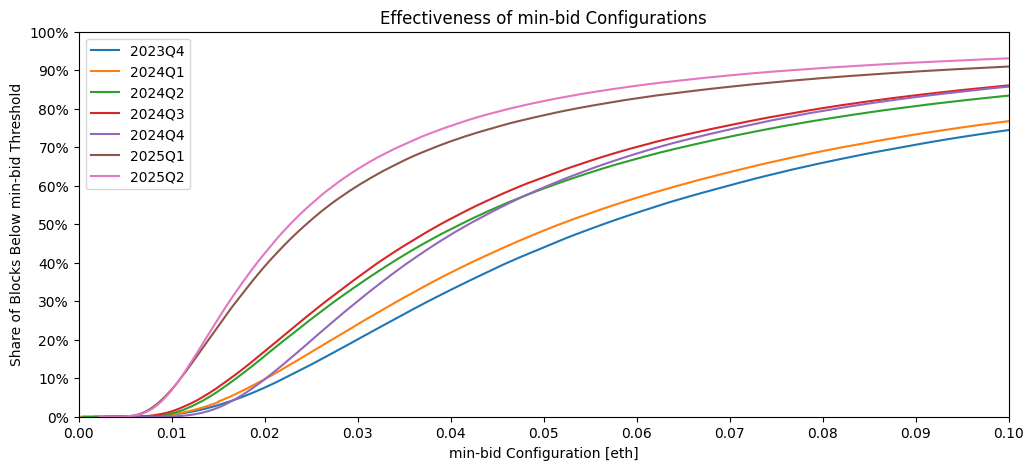

In [9]:
fig, ax = plt.subplots(figsize=(12.0, 5.0))

ax.set_title('Effectiveness of min-bid Configurations')

for q in df['quarter'].unique():
    cdf_q = cdf(df[df['quarter'] == q], 'value_eth')
    ax.plot(cdf_q.index, cdf_q, label=q)

ax.set_xlim(0.0, 0.1)
ax.set_ylim(0.0, 0.9)

ax.set_xticks(np.arange(0, 0.11, 0.01))
ax.set_yticks(np.arange(0, 1.01, 0.10))

ax.set_yticklabels([f'{x:.0%}'.format(x) for x in ax.get_yticks()])

ax.set_xlabel('min-bid Configuration [eth]')
ax.set_ylabel('Share of Blocks Below min-bid Threshold')

ax.legend()

plt.show()

In [10]:
latest_block_datetime = df.iloc[-1]['block_datetime']

In [11]:
block_values_op = (
    df
        .set_index('block_datetime')[['value_eth', 'lido_node_operator']]
        .loc[:latest_block_datetime]
        .groupby('lido_node_operator')
        .rolling(pd.Timedelta(14, 'days'))
        .quantile(0.01)
)

In [12]:
block_values_op_99 = block_values_op.groupby('lido_node_operator').quantile(0.99)
value_eth_threshold_op = 1 / 30
key_ops = block_values_op_99[block_values_op_99 > value_eth_threshold_op].dropna().index.to_list()

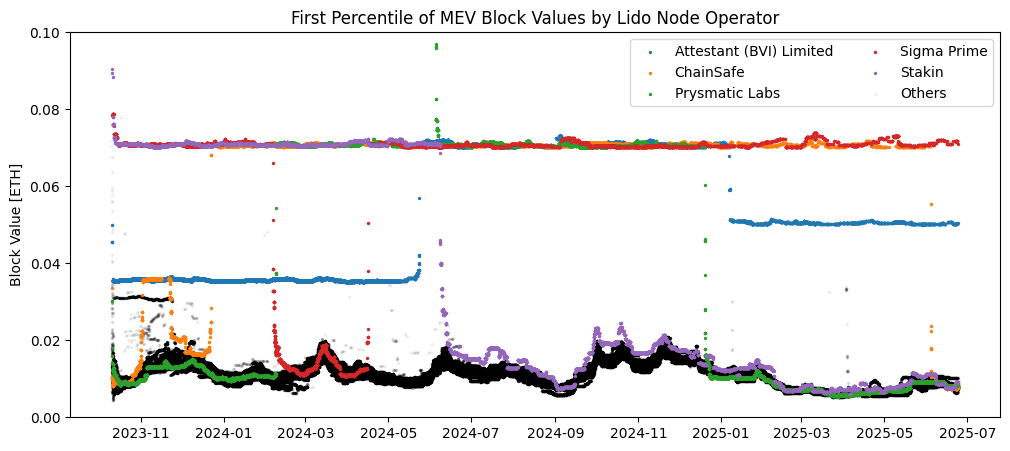

In [13]:
fig, ax = plt.subplots(figsize=(12.0, 5.0))

ax.set_title('First Percentile of MEV Block Values by Lido Node Operator')

for op in block_values_op.index.get_level_values('lido_node_operator').unique():
    block_values_op_plot = block_values_op.loc[op]
    kwargs = {'label': op, 's': 2.0, 'zorder': 10} if op in key_ops else {'alpha': 0.05, 'color': 'k', 's': 2.0}
    ax.scatter(block_values_op_plot.index, block_values_op_plot, **kwargs)

ax.scatter([], [], label='Others', alpha=0.05, color='k', s=2.0)

ax.set_ylim(0, 0.1)

ax.set_ylabel('Block Value [ETH]')

ax.legend(loc='upper right', ncol=2)

plt.show()

In [14]:
top_props = df['proposer_label'].value_counts().head(30).index

In [15]:
block_values_prop = (
    df[df['proposer_label'].isin(top_props)]
        .set_index('block_datetime')[['value_eth', 'proposer_label']]
        .loc[:latest_block_datetime]
        .groupby('proposer_label')
        .rolling(pd.Timedelta(14, 'days'))
        .quantile(0.01)
)

In [16]:
value_eth_threshold_prop = 1 / 3

In [17]:
key_props = (
    block_values_prop[block_values_prop > value_eth_threshold_prop]
        .dropna()
        .index
        .get_level_values('proposer_label')
        .to_list()
)

In [18]:
key_props += [
    'daniel wang',
    'upbit',
]

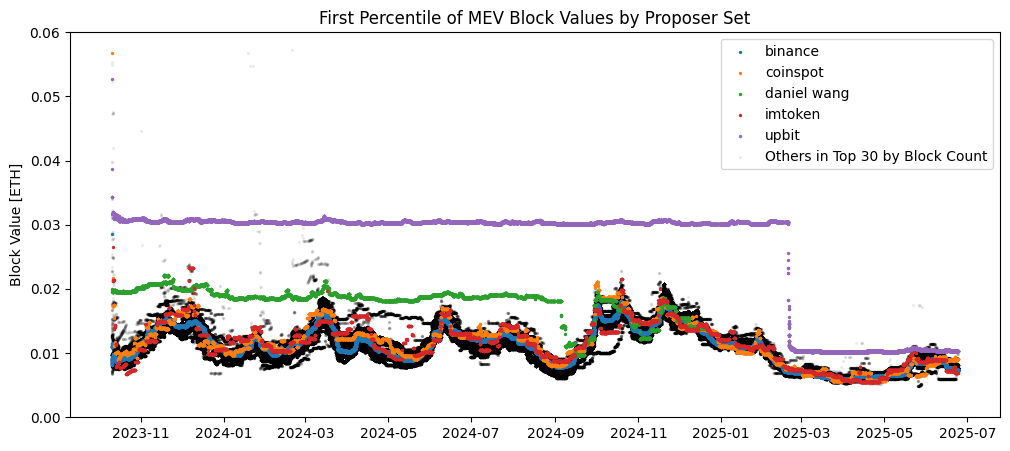

In [19]:
fig, ax = plt.subplots(figsize=(12.0, 5.0))

ax.set_title('First Percentile of MEV Block Values by Proposer Set')

for prop in block_values_prop.index.get_level_values('proposer_label').unique():
    block_values_prop_plot = block_values_prop.loc[prop]
    kwargs = {'label': prop, 's': 2.0, 'zorder': 10} if prop in key_props else {'alpha': 0.05, 'color': 'k', 's': 2.0}
    ax.scatter(block_values_prop_plot.index, block_values_prop_plot, **kwargs)
    
ax.scatter([], [], label='Others in Top 30 by Block Count', alpha=0.05, color='k', s=2.0)

ax.set_ylim(0, 0.06)

ax.set_ylabel('Block Value [ETH]')

ax.legend(loc='upper right', frameon=True)

plt.show()